In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MeanShift
from sklearn.decomposition import PCA
import importlib
from config import *
from utils.load_data import load_dataset

# === setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trial = 3
is_old_trial = trial < TRIAL

# === define dimensions for old trials ===
latent_dim_old = 3
p_dim_old = 1
s_dim_old = 1

if is_old_trial:
    Decoder = importlib.import_module("models.decoder_old").Decoder
    decoder = Decoder(s_dim_old, p_dim_old, latent_dim_old).to(device)
    latent_dim = latent_dim_old
    p_dim = p_dim_old
    s_dim = s_dim_old
    decoder_path = f"models/checkpoints/iteration_{trial}/decoder_ckpt_{trial}.pt"
else:
    from models.decoder import Decoder
    decoder = Decoder(S_DIM, P_DIM, LATENT_DIM).to(device)
    latent_dim = LATENT_DIM
    p_dim = P_DIM
    s_dim = S_DIM
    decoder_path = DECODER_SAVE_PATH

decoder.load_state_dict(torch.load(decoder_path, map_location=device))
decoder.eval()
print("\n✅ Decoder Architecture:\n", decoder)


✅ Decoder Architecture:
 Decoder(
  (hidden_layers): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
  )
  (output_layer): Linear(in_features=32, out_features=4, bias=True)
)


/var/folders/9z/9fdpt4_148s8zzl9h0tr9dgw0000gn/T/ipykernel_42255/2771475684.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  decoder.load_state_dict(torch.load(decoder_p

In [2]:
# === load data ===
P_all, S_all = load_dataset(DATA_PATH)
P_val = P_all[0].unsqueeze(0).to(device)   # (1, P_dim)
S_true = S_all[0].cpu().numpy()            # (S_dim,)
P_unique = torch.unique(P_all, dim=0)
print(f"{len(P_unique)} unique P vectors out of {len(P_all)} total rows.")

# === sampling function ===
def get_S_hats(P_val, num_samples=1000):
    P_tensor = P_val.repeat(num_samples, 1).to(device)
    z_samples = torch.randn((num_samples, latent_dim)).to(device)
    with torch.no_grad():
        S_hats = decoder(z_samples, P_tensor)
    return S_hats.cpu().numpy()

# === peak extraction ===
def get_S_hat_peaks(S_hats, bandwidth=5.0):
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(S_hats)
    return ms.cluster_centers_

# === run sampling and peak extraction ===
S_hats = get_S_hats(P_val, num_samples=1000)
S_hat_peaks = get_S_hat_peaks(S_hats, bandwidth=20.0)


21000 unique P vectors out of 21000 total rows.


<>:6: SyntaxWarning: invalid escape sequence '\h'
<>:6: SyntaxWarning: invalid escape sequence '\h'
/var/folders/9z/9fdpt4_148s8zzl9h0tr9dgw0000gn/T/ipykernel_42255/3629929959.py:6: SyntaxWarning: invalid escape sequence '\h'
  plt.title("KDE of $||\hat{S} - S_{true}||$")


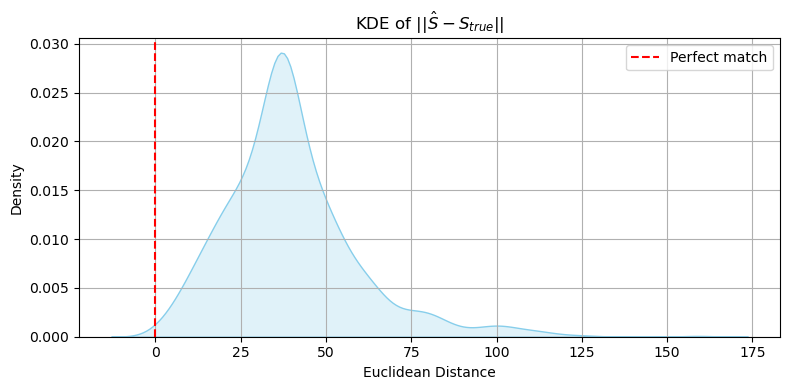

In [ ]:
# === plot 1: KDE of euclidean distances ===
distances = np.linalg.norm(S_hats - S_true, axis=1).astype(np.float64)
plt.figure(figsize=(8, 4))
sns.kdeplot(distances, fill=True, color='skyblue')
plt.axvline(0, color='red', linestyle='--', label="Perfect match")
plt.title("KDE of $||\hat{S} - S_{true}||$")
plt.xlabel("Euclidean Distance")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<>:8: SyntaxWarning: invalid escape sequence '\h'
<>:11: SyntaxWarning: invalid escape sequence '\h'
<>:8: SyntaxWarning: invalid escape sequence '\h'
<>:11: SyntaxWarning: invalid escape sequence '\h'
/var/folders/9z/9fdpt4_148s8zzl9h0tr9dgw0000gn/T/ipykernel_42255/1001690380.py:8: SyntaxWarning: invalid escape sequence '\h'
  plt.scatter(S_pca[:, 0], S_pca[:, 1], alpha=0.3, label="Sampled $\hat{S}$", color='gray')
/var/folders/9z/9fdpt4_148s8zzl9h0tr9dgw0000gn/T/ipykernel_42255/1001690380.py:11: SyntaxWarning: invalid escape sequence '\h'
  plt.title("PCA Projection of $\hat{S}$ Samples with Detected Peaks")


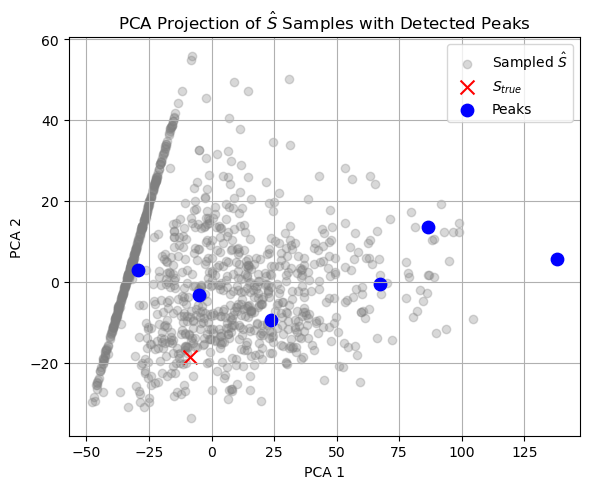

In [4]:
# === plot 2: PCA projection of S_hats, S_true, and peaks ===
pca = PCA(n_components=2)
S_pca = pca.fit_transform(S_hats)
S_true_pca = pca.transform(S_true.reshape(1, -1))
S_peaks_pca = pca.transform(S_hat_peaks)

plt.figure(figsize=(6, 5))
plt.scatter(S_pca[:, 0], S_pca[:, 1], alpha=0.3, label="Sampled $\hat{S}$", color='gray')
plt.scatter(S_true_pca[0, 0], S_true_pca[0, 1], color='red', marker='x', s=100, label="$S_{true}$")
plt.scatter(S_peaks_pca[:, 0], S_peaks_pca[:, 1], color='blue', marker='o', s=80, label="Peaks")
plt.title("PCA Projection of $\hat{S}$ Samples with Detected Peaks")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<>:8: SyntaxWarning: invalid escape sequence '\h'
<>:8: SyntaxWarning: invalid escape sequence '\h'
/var/folders/9z/9fdpt4_148s8zzl9h0tr9dgw0000gn/T/ipykernel_42255/1561536757.py:8: SyntaxWarning: invalid escape sequence '\h'
  axs[i].set_title(f"$\hat{{S}}_{i}$ KDE")


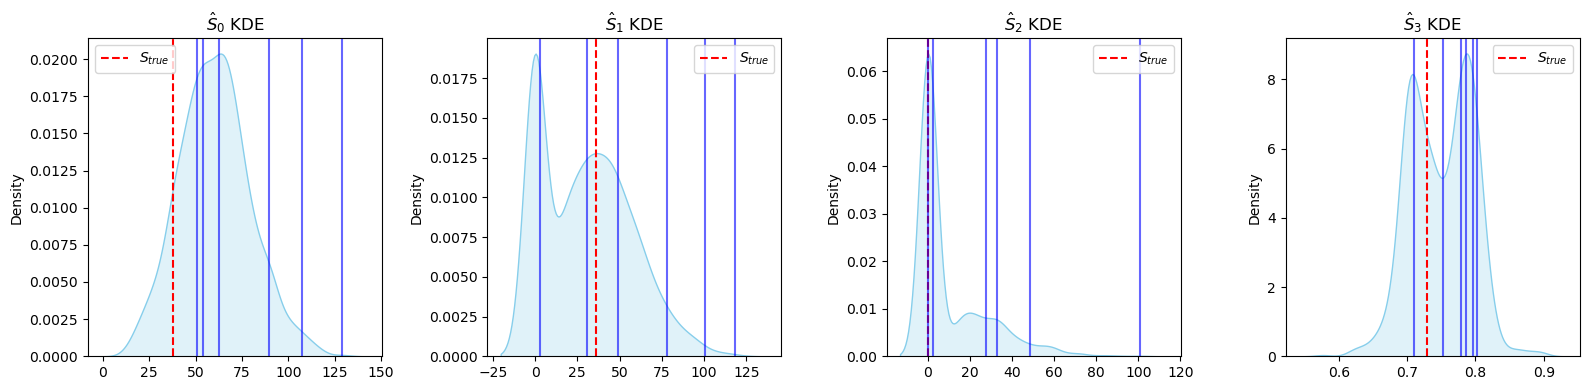

In [5]:
# === plot 3: KDE for each S_i dimension ===
fig, axs = plt.subplots(nrows=1, ncols=S_hats.shape[1], figsize=(4 * S_hats.shape[1], 4))
for i in range(S_hats.shape[1]):
    sns.kdeplot(S_hats[:, i], ax=axs[i], fill=True, color='skyblue')
    axs[i].axvline(S_true[i], color='red', linestyle='--', label="$S_{true}$")
    for peak in S_hat_peaks[:, i]:
        axs[i].axvline(peak, color='blue', linestyle='-', alpha=0.6)
    axs[i].set_title(f"$\hat{{S}}_{i}$ KDE")
    axs[i].legend()
plt.tight_layout()
plt.show()

In [6]:
# === print number of peaks for different bandwidths ===
print("\nBandwidth sensitivity:")
for bw in [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]:
    peaks = get_S_hat_peaks(S_hats, bandwidth=bw)
    print(f"Bandwidth {bw:.1f}: Found {len(peaks)} peak(s)")


Bandwidth sensitivity:
Bandwidth 0.1: Found 939 peak(s)
Bandwidth 0.5: Found 758 peak(s)
Bandwidth 1.0: Found 661 peak(s)
Bandwidth 2.0: Found 487 peak(s)
Bandwidth 5.0: Found 199 peak(s)
Bandwidth 10.0: Found 45 peak(s)
Bandwidth 20.0: Found 6 peak(s)


In [9]:
import tensorflow as tf
import numpy as np
import tensorflow as tf
from functools import partial
from itertools import permutations, product
from utils.mathops import dyad
from utils.fNN_layers import *
from utils.load_data import extract_target_properties

custom_objects = {
    'PermutationEquivariantLayer': PermutationEquivariantLayer,
    'DoubleContractionLayer': DoubleContractionLayer,
    'EnforceIsotropyLayer': EnforceIsotropyLayer,
    'NormalizationLayer': NormalizationLayer
}

# === load max's forward model ===
fNN = tf.keras.models.load_model('utils/max_fNN.h5', custom_objects=custom_objects)  # adjust path if needed
print("✅ Loaded Max's forward model")

# === evaluate each S_hat_peak ===
P_target = P_val.cpu().numpy().flatten()  # shape: (9,)
print("\nEvaluating each S_hat_peak through fNN:")

for i, S_peak in enumerate(S_hat_peaks):
    S_peak_tf = np.expand_dims(S_peak, axis=(0, 1))  # shape: (1, 1, 4)
    # output: shape (1, 1, 3, 3, 3, 3)
    C_pred = fNN(S_peak_tf).numpy()

    # reshape to (1, 3, 3, 3, 3)
    C_pred = C_pred.reshape(1, 3, 3, 3, 3)

    # extract 9 elastic constants → shape (1, 9)
    P_pred = extract_target_properties(C_pred)[0]  # remove batch dim

    error = np.linalg.norm(P_pred - P_target)
    print(f"Peak {i}: ||P_pred - P_true|| = {error:.4f}")
    print("  P_pred:", P_pred.round(3))
    print("  P_true:", P_target.round(3))

✅ Loaded Max's forward model

Evaluating each S_hat_peak through fNN:
Peak 0: ||P_pred - P_true|| = 0.4140
  P_pred: [0.392 0.181 0.182 0.681 0.233 0.682 0.163 0.163 0.221]
  P_true: [0.547 0.189 0.219 0.582 0.226 0.765 0.413 0.399 0.326]
Peak 1: ||P_pred - P_true|| = 0.3260
  P_pred: [0.595 0.227 0.243 0.681 0.255 0.774 0.195 0.214 0.227]
  P_true: [0.547 0.189 0.219 0.582 0.226 0.765 0.413 0.399 0.326]
Peak 2: ||P_pred - P_true|| = 0.3708
  P_pred: [0.725 0.267 0.272 0.741 0.274 0.771 0.228 0.234 0.236]
  P_true: [0.547 0.189 0.219 0.582 0.226 0.765 0.413 0.399 0.326]
Peak 3: ||P_pred - P_true|| = 0.3976
  P_pred: [0.762 0.284 0.284 0.762 0.284 0.762 0.239 0.239 0.239]
  P_true: [0.547 0.189 0.219 0.582 0.226 0.765 0.413 0.399 0.326]
Peak 4: ||P_pred - P_true|| = 0.4222
  P_pred: [0.781 0.297 0.298 0.781 0.298 0.79  0.242 0.243 0.243]
  P_true: [0.547 0.189 0.219 0.582 0.226 0.765 0.413 0.399 0.326]
Peak 5: ||P_pred - P_true|| = 0.4531
  P_pred: [0.803 0.313 0.313 0.802 0.313 0.799 0

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_P_preds_vs_true(P_preds, P_true):
    """
    Plots all P_pred vs P_true bar plots in a 2×3 grid layout.

    Args:
        P_preds (list of np.ndarray): List of predicted property vectors (each shape (9,))
        P_true (np.ndarray): Ground-truth property vector (shape (9,))
    """
    labels = [
        "C1111", "C1122", "C1133", "C2222", "C2233", "C3333",
        "C1212", "C1313", "C2323"
    ]
    num_peaks = len(P_preds)
    rows, cols = 2, 3
    width = 0.35
    x = np.arange(len(labels))

    fig, axs = plt.subplots(rows, cols, figsize=(18, 8))
    axs = axs.flatten()

    for i in range(num_peaks):
        ax = axs[i]
        ax.bar(x - width/2, P_true, width, label='True P', color='lightcoral')
        ax.bar(x + width/2, P_preds[i], width, label='Predicted P', color='skyblue')

        ax.set_title(f"Peak {i + 1}")
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=45)
        ax.grid(True, axis='y', linestyle='--', alpha=0.6)

    # Add legend only once
    axs[0].legend(loc='upper right')
    fig.suptitle("Elastic Components: Predicted vs True for All Peaks", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


Peak 0: ||P_pred - P_true|| = 0.4140
  P_pred: [0.392 0.181 0.182 0.681 0.233 0.682 0.163 0.163 0.221]
  P_true: [0.547 0.189 0.219 0.582 0.226 0.765 0.413 0.399 0.326]
Peak 1: ||P_pred - P_true|| = 0.3260
  P_pred: [0.595 0.227 0.243 0.681 0.255 0.774 0.195 0.214 0.227]
  P_true: [0.547 0.189 0.219 0.582 0.226 0.765 0.413 0.399 0.326]
Peak 2: ||P_pred - P_true|| = 0.3708
  P_pred: [0.725 0.267 0.272 0.741 0.274 0.771 0.228 0.234 0.236]
  P_true: [0.547 0.189 0.219 0.582 0.226 0.765 0.413 0.399 0.326]
Peak 3: ||P_pred - P_true|| = 0.3976
  P_pred: [0.762 0.284 0.284 0.762 0.284 0.762 0.239 0.239 0.239]
  P_true: [0.547 0.189 0.219 0.582 0.226 0.765 0.413 0.399 0.326]
Peak 4: ||P_pred - P_true|| = 0.4222
  P_pred: [0.781 0.297 0.298 0.781 0.298 0.79  0.242 0.243 0.243]
  P_true: [0.547 0.189 0.219 0.582 0.226 0.765 0.413 0.399 0.326]
Peak 5: ||P_pred - P_true|| = 0.4531
  P_pred: [0.803 0.313 0.313 0.802 0.313 0.799 0.245 0.244 0.244]
  P_true: [0.547 0.189 0.219 0.582 0.226 0.765 0.413

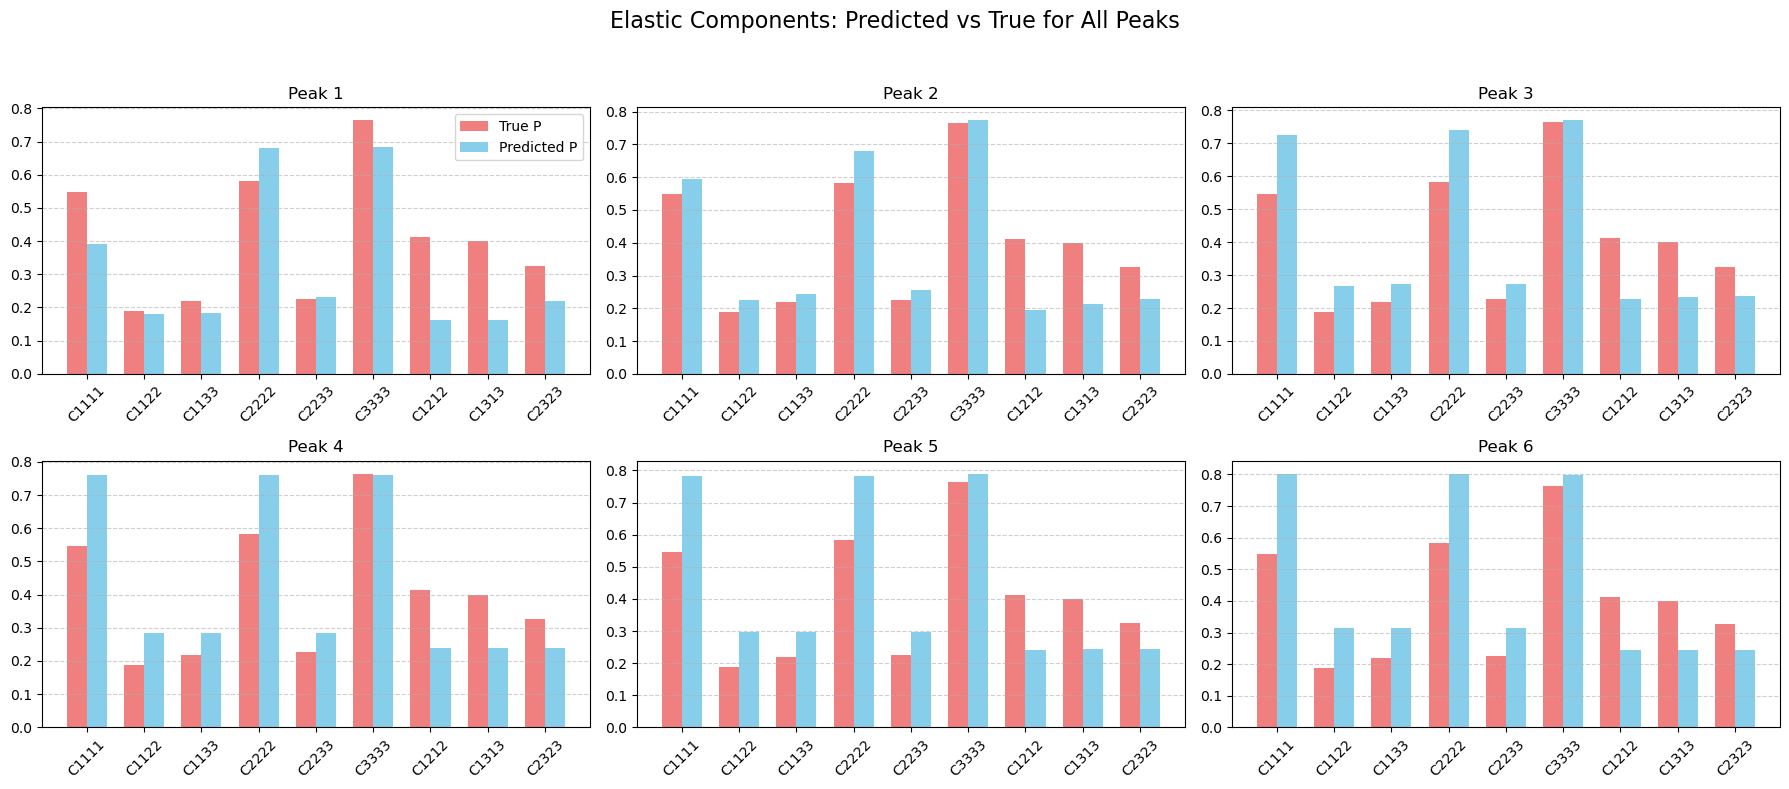

In [ ]:
P_preds = []

for i, S_peak in enumerate(S_hat_peaks):
    S_peak_tf = np.expand_dims(S_peak, axis=(0, 1))
    C_pred = fNN(S_peak_tf).numpy().reshape(1, 3, 3, 3, 3)
    P_pred = extract_target_properties(C_pred)[0]
    P_preds.append(P_pred)

    error = np.linalg.norm(P_pred - P_target)
    print(f"Peak {i}: ||P_pred - P_true|| = {error:.4f}")
    print("  P_pred:", P_pred.round(3))
    print("  P_true:", P_target.round(3))

plot_all_P_preds_vs_true(P_preds, P_target)

In [33]:
closest_idx = np.argmin(np.linalg.norm(S_hats - S_true, axis=1))
closest_dist = np.linalg.norm(S_hats[closest_idx] - S_true)

print(f"Closest sampled S_hat is at index {closest_idx} with distance {closest_dist:.4f}")

Closest sampled S_hat is at index 82 with distance 1.7127
